# Deep Deterministic Policy Gradients (DDPG)

In this notebook we explore a neural network based implementation of the Actor-Critic method for Reinforcement Learning. This algorithm can be seen as the convergence of the breakthroughs that came from the DQN paper with the actor-critic algorithm. This algorithm, DDPG, applies the concepts of experience replay using a replay buffer to mitigate the sequential nature of the data being sampled by interaction with the environment, and instead learns by sampling a batch of random samples of experience saved in the replay buffer for gradient based optimization. 

In general, actor-critic algorithms comprise of two parts, an actor and a critic. Both of these parts are learned from data in the form of multilayer perceptrons rather than manual mappings or hand engineered features. The actor here is our policy network. Given an observation as input, the actor picks out the best action possible based on its weights. Since our actor directly picks out a singular action instead of a probability of actions, we say this follows the "deterministic" policy gradients algorithm, thus the "deterministic" in DDPG. The critic, on the other hand, is used to provide feedback to the actor. The critic network predicts the expected value of a state action pair (action picked out by the actor network), which is what is our actor's goal to maximize.

We use the concept of a target network (as in DQN, refer to /reinforcement_learning/DQN for more) in order to stabilize the learning process. 

DDPG was designed to work well in continuous action spaces, so we run our experiences on the mujoco Half-Cheetah-v4 environment that provides us with a "half" cheetah as an agent whose goal is to travel as much in the forward direction as possible. 

In [1]:
import  gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import numpy as np  

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output

In [2]:
env = gym.make('HalfCheetah-v4')#, render_mode = "human") uncomment to render 
env.reset()

(array([-0.09598893, -0.0029401 , -0.02454283,  0.03510683,  0.01681117,
         0.06927459, -0.00872642, -0.01478541,  0.15124418,  0.02964207,
         0.11308973, -0.06354456,  0.0399986 , -0.03123006, -0.09936888,
         0.02659253, -0.04492479]),
 {})

### Action Space
As mentioned previously, the DDPG algorithm shines in continuous action spaces. Our cheetah has 6 pivots upon which it can execute forces from the -1.0 to 1.0 range, as seen below. 

In [3]:
env.action_space

Box(-1.0, 1.0, (6,), float32)

In [4]:
DIM_ACTIONS = 6

### Exploring the observation space 

In [5]:
observation_space = env.observation_space
observation_space

Box(-inf, inf, (17,), float64)

We have a 17 dimensional observation space. Our observations consist of positional values of the different pivots on the cheetah, their velocities and angular velocities with respect to our different euclidean coordinate frames. 

In [6]:
DIM_OBSERVATIONS = 17

### Building a class for our replay buffer
Nothing changes here v/s the DQN implementation 

In [7]:
#named tuple to store experience 
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

#Experience replay buffer object 
class ReplayMemory(object):

    def __init__(self, capacity):
        #contains a deque of specified buffer length 
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        #add new transition to buffer 
        self.memory.append(Transition(*args))

    #simple function to sample some experience from memory randomly 
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Defining our Critic (Q-Value function)
The differences between this network and the Deep Q Network used for pure DQN are: 
- We're now evaluating a single action that has already been selected by the actor so the first linear layer accepts our observation concatenated with our action 
- Since we're evaluating only one action, we output the value estimate for that singluar action only instead of the set of possible actions giving our network an output dimension of 1 

In [8]:
class critic_Q(nn.Module):

    def __init__(self, len_observation_space, dim_actions):
        super(critic_Q, self).__init__()
        #observations to 128 
        self.layer1 = nn.Linear(len_observation_space + dim_actions, 128)
        #linear transformation 
        self.layer2 = nn.Linear(128, 128)
        #linear downsizing to number of possible actions 
        self.layer3 = nn.Linear(128, 1)

    def forward(self, observation, action):
        x = torch.cat([observation, action], dim=-1)
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

### Actor Network 
A multilayer perceptron that accepts our observation as input and outputs a deterministic action to be taken at timestep t 

In [9]:
class actor_Policy(nn.Module): 
    def __init__(self, len_observation_space, dim_actions):
        super(actor_Policy, self).__init__()
        #observations to 128 
        self.layer1 = nn.Linear(len_observation_space, 128)
        #linear transformation 
        self.layer2 = nn.Linear(128, 128)
        #deterministically outputting a single action 
        self.layer3 = nn.Linear(128, dim_actions) #output has the specified dimensionality to specify actions with respect to 
                                                  #all action dimensions (in the case of our example, this is 6)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return torch.tanh(self.layer3(x))

In [10]:
TRAIN_AFTER_STEPS = 2e5

### Optimization Function Overview

The following function represents the optimization steps. If our replay buffer is at capacity, we:

- Sample a batch of transitions from memory. This initial step involves drawing a selection of varied transitions from our repository of stored experiences.

- Compute the expected value using the critic network. 

- Run inference on target network to determine what our "next action" would be given our sampled "next_state"

- Compute the target value by running inference on the target critic given the next state and next action from the above step 

- Given the predicted value, sampled reward and target next state/action value, compute the TD error

- Compute the loss between the predicted and target values and then optimize the critic network. 

- Use the negative log of the mean value of the values outputted by the critic as the loss for the actor. We want to maximize this mean. 

Through this sequence of steps, the function continuously enhances the model's predictive performance along with control performance by learning from past errors.


In [11]:
def optimize_model(gamma, batch_size, memory, actor, critic, target_actor, target_critic, loss_fn, actor_optimizer, critic_optimizer, device):
    
    if len(memory) < TRAIN_AFTER_STEPS: 

        return None, None
    
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions)) #batches our data as follows: ((state1, state2, ..), (action1, action2, ...), ...)
    
    non_final_mask = torch.tensor([s is not None for s in batch.next_state],
                                  device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    states = torch.cat(batch.state).to(device)
    actions = torch.tensor(np.stack(batch.action), dtype=torch.float32, device=device)
    rewards = torch.tensor(np.stack(batch.reward), dtype=torch.float32, device=device)

    
    predicted_values = critic(states, actions) 
    
    with torch.no_grad():
        next_actions = target_actor(non_final_next_states)  
    
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_critic(non_final_next_states, next_actions).squeeze(1)  
    
    target_values = (next_state_values * gamma) +rewards # if the state is non terminal, we add to it the expected value of the next state 
    td_error = target_values - predicted_values 
    
    loss = loss_fn(predicted_values, target_values.unsqueeze(1))
    critic_optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(critic.parameters(), 100)
    critic_optimizer.step()

    actor_loss = -critic(states,actor(states)).mean()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()

    return loss.cpu().detach().numpy(), actor_loss.cpu().detach().numpy()

In [12]:
def trainer(num_epochs, num_cycles, num_rollouts, train_steps, batch_size, target_actor, actor, target_critic, critic, gamma, device, \
            replay_buffer, actor_optimizer, critic_optimizer, tau, epochs_till_buffer_full): 
    
    reward_per_episode = []
    actor_loss_per_episode = []
    critic_loss_per_episode = []
    noise_factor = 0.5 

    for epoch in range(num_epochs): 

        rewards_per_cycle = []
        critic_losses = []
        actor_losses = []

        if not epoch % 250 and epoch > 0 and epoch < 749: 
            epoch-=0.1
        
        for cycle in range(num_cycles): 

            cum_reward = 0
            epoch_end = False
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32, device = device).unsqueeze(0)
            
            for rollout in range(num_rollouts):

                #select action based on our policy network 
                action = actor(state).squeeze().cpu().detach().numpy()
                
                #Add noise to our action vector to introduce some level of exploration 
                noise = np.random.normal(0, noise_factor, size=env.action_space.shape) # Adjust the scale (0.2) as needed
                
                action = np.clip(action + noise, env.action_space.low, env.action_space.high) #clip so that our actions never exceed the allowed thresholds 
                next_state, reward, terminated, truncated, _ = env.step(action)

                epoch_end = terminated or truncated

                cum_reward+=reward
                
                if not terminated: 
                    next_state = torch.tensor(next_state, dtype=torch.float32, \
                        device = device).unsqueeze(0) #we only care about next_state if the state is non terminal
                else: 
                    next_state = None
                
                replay_buffer.push(state, action, next_state, reward)
                state = next_state
     

            #we only traina few times each epoch to avoid overfitting : 
            
            for _ in range(train_steps): 
                critic_loss, actor_loss = optimize_model(gamma, batch_size, replay_buffer, actor, critic, target_actor, target_critic,loss_fn=torch.nn.MSELoss(size_average=True), actor_optimizer=actor_optimizer,\
                            critic_optimizer= critic_optimizer, device=device)
                if actor_loss is not None and critic_loss is not None: 
                    actor_losses.append(actor_loss)
                    critic_losses.append(critic_loss)
    
                target_critic_state_dict = target_critic.state_dict()
                critic_state_dict = critic.state_dict()

                target_actor_state_dict = target_actor.state_dict()
                actor_state_dict = actor.state_dict()
                
                # we update our target networks with the weights of our primary networks (they really need to clear up terminology here lol)
                
                for key in actor_state_dict.keys():
                    #we perform soft updates as follows:
                    # θ′ ← τ θ + (1 −τ )θ′
                    target_actor_state_dict[key] = actor_state_dict[key]*tau + target_actor_state_dict[key]*(1-tau)
                    target_actor.load_state_dict(target_actor_state_dict)
                
                for key in critic_state_dict.keys():    
                    target_critic_state_dict[key] = critic_state_dict[key]*tau + target_critic_state_dict[key]*(1-tau)
                    target_critic.load_state_dict(target_critic_state_dict)
                    
                rewards_per_cycle.append(cum_reward)
        


        reward_per_episode.append(sum(rewards_per_cycle) / len(rewards_per_cycle))    
        clear_output(wait=True) # Clear the output of the current cell receiving output
        plt.plot(reward_per_episode)
        plt.title('Average Cumulative Reward per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Cumulative Reward')
        plt.show()
        
        if len(critic_losses) > 0: 
            actor_loss_per_episode.append(sum(actor_losses) / len(actor_losses))       
            critic_loss_per_episode.append(sum(critic_losses) / len(critic_losses))       

            plt.plot(actor_loss_per_episode)
            plt.title('Actor Loss per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Actor loss')
            plt.show()

            plt.plot(critic_loss_per_episode)
            plt.title('Critic Loss per Epoch')
            plt.xlabel('Epoch')
            plt.ylabel('Critic Loss')
            plt.show()

In [13]:
#hyperparams 
NUM_EPOCHS = 1500  
GAMMA = 0.99 
ALPHA_ACTOR = 1e-4 
ALPHA_CRITIC = 3e-4
BATCH_SIZE = 64 #we want a relatively large batch size to leverage GPU parallelism but at the same time we want this number to be far 
                #smaller than our memory capacity so that we can sample randomly at the same time
NUM_CYCLES = 100 
TRAIN_STEPS = 5 
TAU = 0.001
NUM_ROLLOUTS = 30
L2_REG = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BUFFER_SIZE = 1000000

/home/aryaman.pandya/ml_accel/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [14]:
replay_buffer = ReplayMemory(BUFFER_SIZE)

actor = actor_Policy(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)
target_actor = actor_Policy(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)

critic = critic_Q(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)
target_critic = critic_Q(len_observation_space=DIM_OBSERVATIONS, dim_actions=DIM_ACTIONS)

actor.to(DEVICE)
target_actor.to(DEVICE)

critic.to(DEVICE)
target_critic.to(DEVICE)

target_actor.load_state_dict(actor.state_dict())
target_critic.load_state_dict(critic.state_dict())

<All keys matched successfully>

In [15]:
steps_per_epoch = NUM_ROLLOUTS * NUM_CYCLES
train_after_epochs = TRAIN_AFTER_STEPS / steps_per_epoch
epochs_till_buffer_full = BUFFER_SIZE / steps_per_epoch
train_samples_per_epoch = TRAIN_STEPS * BATCH_SIZE * NUM_CYCLES
print(f"steps per epoch: {steps_per_epoch}, training starts after {train_after_epochs} epochs, the replay buffer fills up in {epochs_till_buffer_full} epochs, we train based on {train_samples_per_epoch} samples\
 per epoch")

steps per epoch: 3000, training starts after 66.66666666666667 epochs, the replay buffer fills up in 333.3333333333333 epochs, we train based on 32000 samples per epoch


In [16]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=ALPHA_ACTOR, weight_decay=L2_REG)

In [17]:
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=ALPHA_CRITIC, weight_decay=L2_REG)

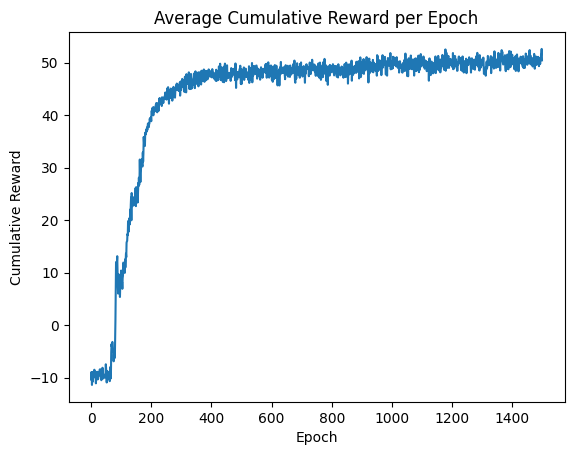

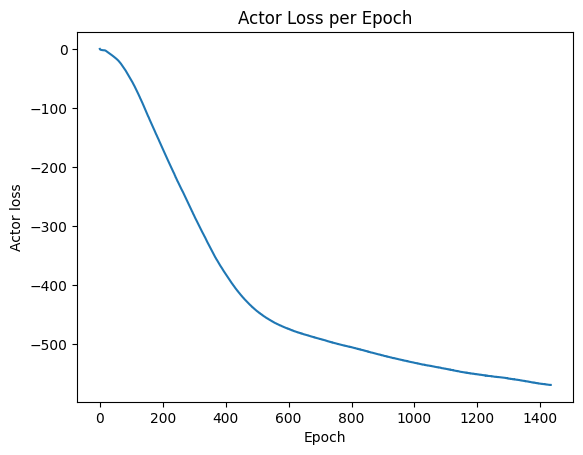

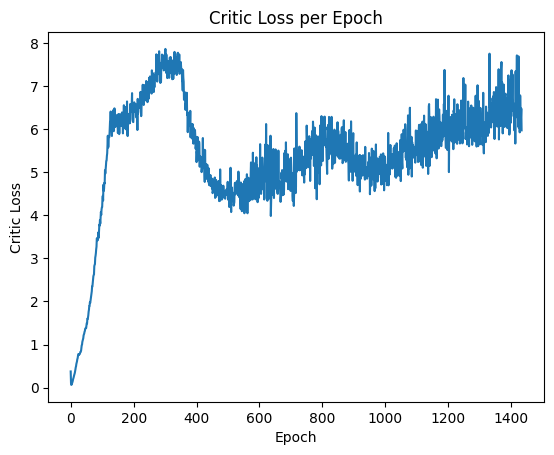

In [18]:
trainer(num_epochs=NUM_EPOCHS, num_cycles=NUM_CYCLES,num_rollouts=NUM_ROLLOUTS, train_steps=TRAIN_STEPS, batch_size=BATCH_SIZE, actor=actor, critic=critic, target_actor=target_actor, target_critic=target_critic,\
         gamma=GAMMA, device=DEVICE, replay_buffer=replay_buffer, actor_optimizer=actor_optimizer, critic_optimizer=critic_optimizer, tau=TAU, epochs_till_buffer_full= epochs_till_buffer_full)

In [22]:
env = gym.make('HalfCheetah-v4', render_mode = "human")


In [23]:
NUM_TEST_CYCLES = 100 

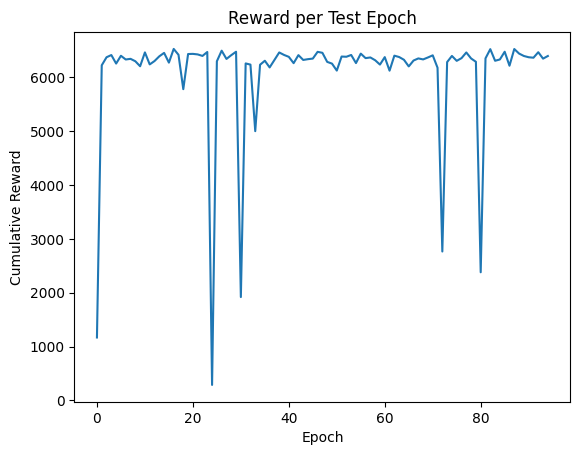

In [24]:
test_rewards = []
for test in range(NUM_TEST_CYCLES): 
    
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device = DEVICE).unsqueeze(0)
    test_epoch_end = False
    cum_reward = 0 

    while not test_epoch_end: 
        
        with torch.no_grad():
            
            action = actor(state).squeeze().cpu().detach().numpy()
            
            next_state, reward, terminated, truncated, _ = env.step(action)

            test_epoch_end = terminated or truncated

            cum_reward+=reward
            if not terminated: 
                    next_state = torch.tensor(next_state, dtype=torch.float32, \
                        device = DEVICE).unsqueeze(0) #we only care about next_state if the state is non terminal
            else: 
                next_state = None

            state = next_state
    test_rewards.append(cum_reward)
    
    clear_output(wait=True)
    plt.plot(test_rewards)
    plt.title('Reward per Test Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Cumulative Reward')
    plt.show()

## Thoughts on results (09/09)

After training for a significant amount of time, although the cheetah was able to learn a policy that increased reward, it was a local maxima. The cheetah learned to flip to its back in the first few timesteps and then worm its way really fast forwards. While this is progress from previous training runs, it's not ideal. We can get an average test reward of around 1850, but we know that within this environment its possible for us to hit higher rewards up to the 10,000 range. 

My initial hunch is to reduce the critic's learning rate. I think the critic highly favoring such scenarios might be steering the actor in the direction of this policy, and that decreasing the critic's learning rate potentially by an order of magnitude might allow for more exploration taking our agent closer to an actual optimal policy. 

I'm not sure changing the exploration rate would do anything, considering a noise factor of 0.3 is already pretty high. 

In [ ]:
average_test_reward = sum(test_rewards) / len(test_rewards)

## Thoughts on results (09/11)

I tweaked the hyperparameters to do a few things differently- sample more before allowing training, start with a higher noise factor then decay, and run smaller rollouts to reduce the temporal dependence of samples. This worked really well and produced a policy in which our cheetah actually runs! In the reward plot above for the test runs, we can notice some episodes have lower reward than others (still in the thousands). This represents episodes where the cheetah ran really fast and then fell. 

Due to the low hyperparameter NUM_ROLLOUTs, our cheetah doesn't encounter too many scenarios in which it needs to perform a stand up/recovery maneuver. A few different ways to solve this issue could be: 

- Increase number of rollouts when geneterating initial (random) training data
- Re-run training on pre-trained model, this time increase the number of rollouts so that we have to learn to recover. 

In [ ]:
# save model weights for future reference/finetuning purposes (as highlighted in the notes above)

torch.save(critic.state_dict(), 'critic_state_dict.pth')
torch.save(actor.state_dict(), 'actor_state_dict.pth')